In [ ]:
print("aaaaasdsad")

CUDA verfügbar: True
Anzahl der CUDA-Geräte: 1
CUDA-Gerät: NVIDIA GeForce RTX 3060 Ti
Searching for 'charizard'
Searching for 'blastoise'
Searching for 'venusaur'
CUDA verfügbar: True
Anzahl der CUDA-Geräte: 1
CUDA-Gerät: NVIDIA GeForce RTX 3060 Ti


AttributeError: 'Sequential' object has no attribute 'to_gpu'

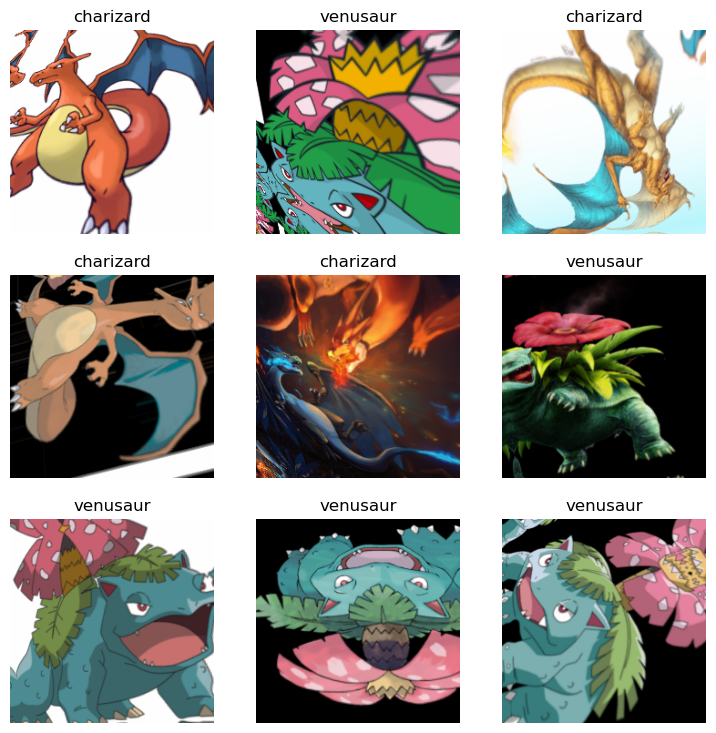

In [1]:
from fastai.vision.all import *
from duckduckgo_search import DDGS
import ipywidgets as widgets
from ipywidgets import VBox, HBox
from IPython.display import display
import torch

print("CUDA verfügbar:", torch.cuda.is_available())
print("Anzahl der CUDA-Geräte:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("CUDA-Gerät:", torch.cuda.get_device_name(0))
    default_device = torch.device("cuda")
else:
    default_device = torch.device("cpu")

# Stellen Sie sicher, dass fastai die GPU verwendet
defaults.device = default_device

In [2]:
def search_images_ddg(term, max_images=5):
    print(f"Searching for '{term}'")
    # Search for images by using DuckDuckGo. With is a context manager that 
    # ensures that the session is closed after the search.
    with DDGS() as ddgs:
        return L(ddgs.images(term, max_results=max_images)).itemgot('image')

# Create three cateogories for the pokemon
pokemon_types = 'charizard', 'blastoise', 'venusaur'

# Instantiate a path object
path = Path('pokemon')

# Erstellen des Hauptverzeichnisses und Herunterladen der Bilder
if not path.exists():
    path.mkdir()

for o in pokemon_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o}')
    download_images(dest, urls=results)

# Überprüfen der Bilder
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

# Erstellen des DataBlock
pokemon = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

# Erstellen der DataLoaders
dls = pokemon.dataloaders(path)

# Training des Modells
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

# Exportieren des Modells
learn.export('pokemon_classifier.pkl')



Searching for 'charizard'
Searching for 'blastoise'
Searching for 'venusaur'


epoch,train_loss,valid_loss,error_rate,time
0,1.685615,0.833372,0.326923,00:08


/home/cengiz/miniconda3/envs/pokemon/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/cengiz/miniconda3/envs/pokemon/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.416179,0.227528,0.076923,00:08
1,0.271903,0.043141,0.000000,00:09
2,0.191114,0.007945,0.000000,00:09
3,0.145927,0.002360,0.000000,00:10


/home/cengiz/miniconda3/envs/pokemon/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/cengiz/miniconda3/envs/pokemon/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/cengiz/miniconda3/envs/pokemon/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/cengiz/miniconda3/envs/pokemon/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/cengiz/miniconda3/envs/pokemon/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warni

In [12]:
from fastai.vision.all import *
import ipywidgets as widgets
from ipywidgets import VBox, HBox
from IPython.display import display
from PIL import Image
from io import BytesIO
import numpy as np

# Laden des Modells für Inferenz
learn_inf = load_learner('pokemon_classifier.pkl')

# Erstellen der Widgets
btn_upload = widgets.FileUpload(accept='image/*', multiple=False)
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    if not btn_upload.value:
        return
    
    # Laden des Bildes aus dem memoryview-Objekt
    img = Image.open(BytesIO(btn_upload.value[0].content))
    
    # Konvertieren des Bildes in RGB
    img = img.convert('RGB')
    
    # Konvertieren des Bildes in ein numpy-Array für die Vorhersage
    img_array = np.array(img)
    
    out_pl.clear_output()
    with out_pl:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    # Erstellen eines FastAI-Image-Objekts für die Vorhersage
    fastai_img = PILImage.create(img_array)
    
    pred, pred_idx, probs = learn_inf.predict(fastai_img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

# Zusammensetzen der Benutzeroberfläche
widgets_panel = VBox([
    widgets.Label('Select your Pokemon!'),
    btn_upload,
    btn_run,
    out_pl,
    lbl_pred
])

display(widgets_panel)